# Video Classification with VideoSwin


In this notebook, we will show how to fine-tune [**VideoSwin**](https://arxiv.org/abs/2106.13230) model for a classification task. The official release is in [`torch`](https://github.com/SwinTransformer/Video-Swin-Transformer). This notebook is the [`keras 3`](https://github.com/innat/VideoSwin) reimplementation. The official PyTorch weight has been converted to Keras 3 compatible. This implementaiton supports to run the model on multiple backend, i.e. TensorFlow, PyTorch, and Jax. In this notebook, we will be working with TensorFlow backend.


## VideoSwin

**VideoSwin** is a pure transformer based video modeling algorithm, attained top accuracy on the major video recognition benchmarks. In this model, the author advocates an inductive bias of locality in video transformers, which leads to a better speed-accuracy trade-off compared to previous approaches which compute self-attention globally even with spatial-temporal factorization. The locality of the proposed video architecture is realized by adapting the [**Swin Transformer**](https://arxiv.org/abs/2103.14030) designed for the image domain, while continuing to leverage the power of pre-trained image models.


In this quick demonstration, we will show how to fine-tune a custom dataset with **VideoSwin** models. We will be using a videoswin as a backbone and add a custom head on top of it.   


<td>
<a target="_blank" href="?"><img src="https://user-images.githubusercontent.com/17668390/176064420-46cbf547-0d17-4438-a791-d23e17eff5a9.png" />Try on Gradio</a>
</td>

## Dataset

This is where you can use your own data. For demonstration purpose, we have created a sub-set of Kintetics dataset with `5` categories to represent a custom dataset. Here is the link of [KineticsTop5](https://huggingface.co/datasets/innat/KineticsTop5) datast. You can choose your own dataset and dataloader.





In [1]:
!pip install huggingface_hub decord -q

In [2]:
import os, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from decord import VideoReader

from huggingface_hub import hf_hub_download
from mpl_toolkits.axes_grid1 import ImageGrid

warnings.simplefilter(action="ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
import keras
from keras import layers

tf.__version__, keras.__version__

('2.15.0', '3.0.5')

In [3]:
physical_devices = tf.config.list_physical_devices("GPU")
keras.mixed_precision.set_global_policy("mixed_float16")
strategy = tf.distribute.MirroredStrategy()

HOME = os.getcwd()
tf.__version__, HOME, strategy

('2.15.0',
 '/kaggle/working',
 <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy at 0x7fce35fc3d60>)

## Utils

In [4]:
def show_sequence(seq, sample=8, title=""):
    """Plot a sequence of images horizontally"""
    # clip is [T, H, W, 3]
    assert seq.shape[-1] == 3
    fig = plt.figure(figsize=(20, 2.5))
    fig.suptitle(title, fontsize=16)
    grid = ImageGrid(fig, 111, nrows_ncols=(1, sample), axes_pad=0.1)
    for ax, img in zip(grid, seq):
        ax.imshow(img.astype("uint8"))
        ax.set_axis_off()
    plt.show()
    return

## Data



In [5]:
%cd {HOME}
!mkdir {HOME}/data
%cd {HOME}/data

/kaggle/working
/kaggle/working/data


In [6]:
hf_dataset_identifier = "innat/KineticsTop5"
filename = "kinetics_top5_tiny.zip"
file_path = hf_hub_download(
    repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset"
)
!unzip -q {file_path}

kinetics_top5_tiny.zip:   0%|          | 0.00/532M [00:00<?, ?B/s]

In [7]:
train_set = f"{HOME}/data/train"
test_set = f"{HOME}/data/test"
class_folders = os.listdir(train_set)
label2id = {label: i for i, label in enumerate(class_folders)}
id2label = {v: k for k, v in label2id.items()}
id2label

{0: 'squat',
 1: 'reading_newspaper',
 2: 'reading_book',
 3: 'opening_bottle',
 4: 'sneezing'}

In [8]:
def create_dataframe(path):
    data = []
    for class_name in os.listdir(path):
        class_dir = os.path.join(path, class_name)
        if os.path.isdir(class_dir) and class_name in label2id:
            for video_file in os.listdir(class_dir):
                video_path = os.path.join(class_dir, video_file)
                data.append(
                    {
                        "video_path": os.path.abspath(video_path),
                        "label": label2id[class_name],
                        "class_name": class_name,
                    }
                )
    df = pd.DataFrame(data)
    df = df.sample(frac=1).reset_index(drop=True)
    return df


train_df = create_dataframe(train_set)
test_df = create_dataframe(test_set)
train_df.shape, test_df.shape

((1006, 3), (243, 3))

In [9]:
test_df.head()

,video_path,label,class_name
0,/kaggle/working/data/test/reading_newspaper/hq...,1,reading_newspaper
1,/kaggle/working/data/test/reading_book/jpTXH1E...,2,reading_book
2,/kaggle/working/data/test/opening_bottle/O2BP1...,3,opening_bottle
3,/kaggle/working/data/test/reading_book/yPCC6O5...,2,reading_book
4,/kaggle/working/data/test/sneezing/UZPlojt8zhE...,4,sneezing


# Data Loader

Reading the video data from dataloader in training time can be challenging. We can leverage [TFRecord](https://www.tensorflow.org/tutorials/load_data/tfrecord) format, but due to the cost of disk space, we will skip that. For now, we will be using [`decord`](https://github.com/dmlc/decord) for video reader. It supports both GPUs and TPUs.



In [10]:
input_size = 224
num_frame = 32
sampling_rate = 2
batch_size = 4 * strategy.num_replicas_in_sync

In [11]:
def read_video(file_path):
    vr = VideoReader(file_path.numpy().decode("utf-8"))
    frames = vr.get_batch(range(len(vr))).asnumpy()
    return format_frames(frames, output_size=(input_size, input_size))

def format_frames(frame, output_size):
    frame = tf.image.convert_image_dtype(frame, tf.uint8)
    frame = tf.image.resize(frame, size=list(output_size))
    return frame

def load_video(file_path, label):
    video = tf.py_function(func=read_video, inp=[file_path], Tout=tf.float32)
    video.set_shape([None, None, None, 3])
    return video, tf.cast(label, dtype=tf.float32)

The raw **Kinetics** data comes with variable size of **input frame** and **frame size**. We will resize the video to the target shape (i.e. `224`). For **VideoSwin** model, the clip length is `32`. We will use frame rate `2` which is the stride or step from a frame to next frame. We will also take `1` clip from a video. However, in literature for evaluation, it's common to take `num_clips > 1` from each clip and average the results for final prediction For **VideoSwin**, check the official [note](https://github.com/SwinTransformer/Video-Swin-Transformer/blob/db018fb8896251711791386bbd2127562fd8d6a6/configs/recognition/swin/swin_tiny_patch244_window877_kinetics400_1k.py#L48-L52) on this. But here for simplicity cause, we will skip that.


Sampling strategy for frame selection is another important factor which might need another attention. It can significantly differs the reported scores. In this notebook, we will be using [uniform sampling](https://gist.github.com/innat/205075992360d8d7a241c7f1013866a8) for frame selection.

In [12]:
def uniform_temporal_subsample(
    x, num_samples, clip_idx, total_clips, frame_rate=1, temporal_dim=-4
):
    t = tf.shape(x)[temporal_dim]
    max_offset = t - num_samples * frame_rate
    step = max_offset // total_clips
    offset = clip_idx * step
    indices = tf.linspace(
        tf.cast(offset, tf.float32),
        tf.cast(offset + (num_samples - 1) * frame_rate, tf.float32),
        num_samples,
    )
    indices = tf.clip_by_value(indices, 0, tf.cast(t - 1, tf.float32))
    indices = tf.cast(tf.round(indices), tf.int32)
    return tf.gather(x, indices, axis=temporal_dim)


def clip_generator(image, num_frames=32, frame_rate=1, num_clips=1, crop_size=224):
    clips_list = []
    for i in range(num_clips):
        frame = uniform_temporal_subsample(
            image, num_frames, i, num_clips, frame_rate=frame_rate, temporal_dim=0
        )
        clips_list.append(frame)
    video = tf.stack(clips_list)
    video = tf.reshape(video, [num_clips * num_frames, crop_size, crop_size, 3])
    return video

In [13]:
def create_dataloader(df, batch_size, shuffle=True, drop_reminder=True):
    ds = tf.data.Dataset.from_tensor_slices(
        (df["video_path"].values, df["label"].values)
    )
    ds = ds.repeat() if shuffle else ds
    ds = ds.shuffle(8 * batch_size) if shuffle else ds
    ds = ds.map(load_video, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(
        lambda x, y: (clip_generator(x, num_frame, sampling_rate, num_clips=1), y),
        num_parallel_calls=tf.data.AUTOTUNE,
    )
    ds = ds.batch(batch_size, drop_remainder=drop_reminder)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [14]:
train_ds = create_dataloader(train_df, batch_size, shuffle=True)
test_ds = create_dataloader(test_df, batch_size, shuffle=False)

**Visualize**

In [15]:
temp_ds = create_dataloader(test_df, 5, shuffle=False)
x, y = next(iter(temp_ds))
x.shape, y

(TensorShape([5, 32, 224, 224, 3]),
 <tf.Tensor: shape=(5,), dtype=float32, numpy=array([1., 2., 3., 2., 4.], dtype=float32)>)

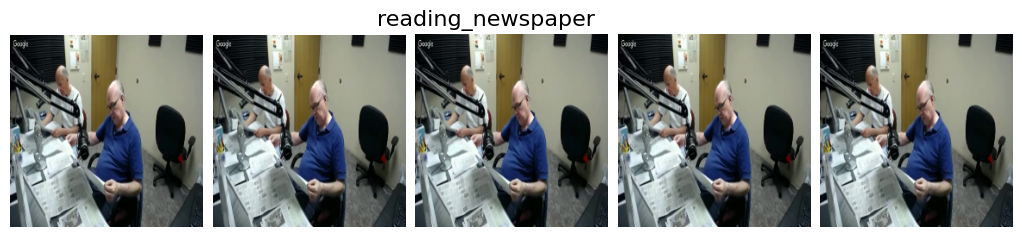

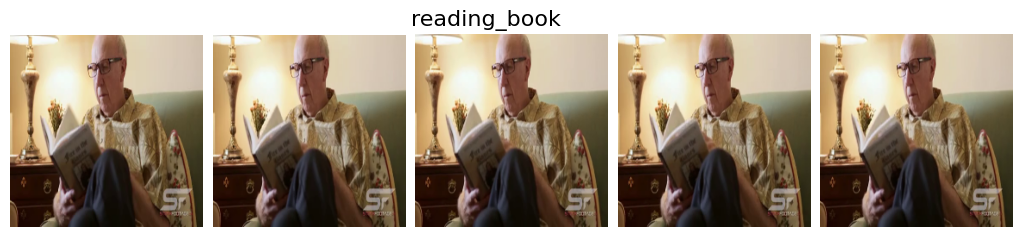

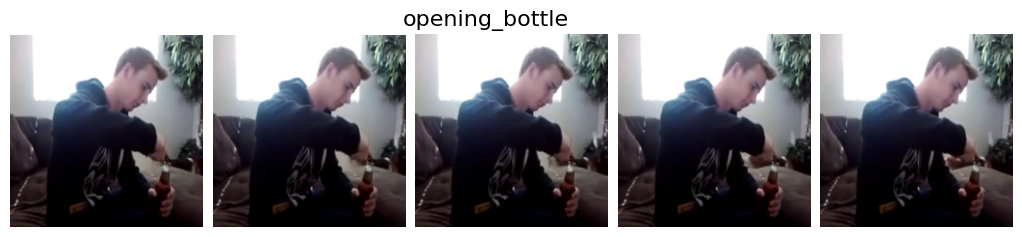

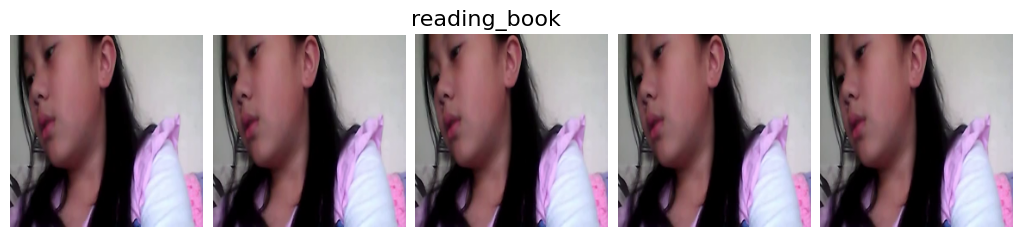

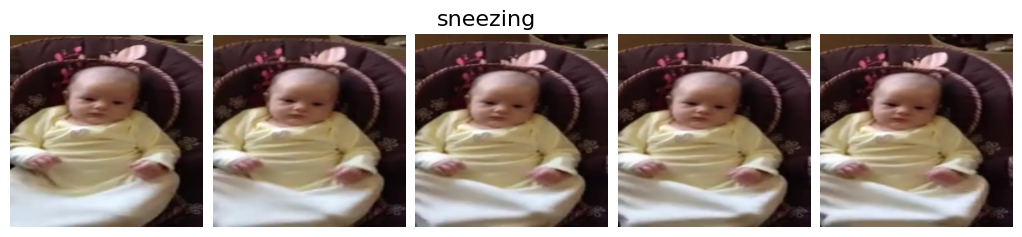

In [16]:
for i in range(len(x)):
    show_sequence(x.numpy()[i], sample=5, title=id2label[y[i].numpy()])

# Model

As mentioned, we are using a custom **Kinetics-5** dataset. We will be using **VideoSwin** model with **Something-Something-V2** pretrained checkpoint (`no top`). We will freeze the backbone and only train the custom head for downstream task.

In [17]:
%cd {HOME}
!git clone https://github.com/innat/VideoSwin.git
%cd VideoSwin
!pip install -q -e . 

/kaggle/working
Cloning into 'VideoSwin'...
remote: Enumerating objects: 771, done.
remote: Counting objects: 100% (237/237), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 771 (delta 175), reused 175 (delta 129), pack-reused 534
Receiving objects: 100% (771/771), 3.55 MiB | 24.70 MiB/s, done.
Resolving deltas: 100% (457/457), done.
/kaggle/working/VideoSwin


In [18]:
from videoswin.backbone import VideoSwinBackbone
from videoswin.model import VideoSwinB

In [19]:
!wget https://github.com/innat/VideoSwin/releases/download/v2.0/videoswin_base_something_something_v2.weights.h5 -q

In [20]:
with strategy.scope():
    backbone = VideoSwinB(
        include_top=False,
        include_rescaling=True, 
        input_shape=(32, 224, 224, 3), 
        window_size=(16, 7, 7),
    )
    backbone.load_weights(
        'videoswin_base_something_something_v2.weights.h5'
    )
    backbone.trainable=False
    inputs = backbone.input
    x = backbone(inputs)
    x = keras.layers.GlobalAveragePooling3D(name="avg_pool")(x)
    outputs = layers.Dense(
        len(class_folders), 
        dtype="float32", 
        activation=None
    )(x)
    model = keras.Model(inputs, outputs)

In [21]:
with strategy.scope():
    # compile the model
    model.compile(
        optimizer=keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-4),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="acc"),
        ],
    )

In [22]:
history = model.fit(
    train_ds,
    validation_data=test_ds,
    steps_per_epoch=len(train_df) // batch_size,
    validation_steps=len(test_df) // batch_size,
    epochs=1,
)

251/251 ━━━━━━━━━━━━━━━━━━━━ 671s 3s/step - acc: 0.5768 - loss: 1.1383 - val_acc: 0.7958 - val_loss: 0.5823
